In [2]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.3 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=acc300bdace3cfd76088e437ba7a9da2b3cce71730276a755cc40ad159d04d70
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [32]:
import os
import shap
import json
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna.distributions as D

from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import BaseCrossValidator, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm
from collections import Counter

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

## Вспомогательные функции

In [33]:
def plot_pr_curve(test_y, predictions):
    precision, recall, _ = precision_recall_curve(test_y, predictions)
    plt.plot(recall, precision, marker='.', label='catboost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    plt.plot(fpr, tpr, marker='.', label='catboost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_fit_curves(model):
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['learn']['AUC'],
        label='learn'
    )
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['validation']['AUC'],
        label='val'
    )
    plt.legend()
    plt.show()

def plot_target_segment(test_y, predictions):
    hist_df = pd.DataFrame(
        {
            'target':test_y.values,
            'proba':predictions
        }
    )
    hist_df = hist_df.sort_values(by='proba', ascending=False)
    
    num_segments = 20
    segment_length = len(hist_df) // num_segments
    array_21 = [21]*(len(hist_df)-num_segments*segment_length)
    hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21
    
    hist_df = hist_df.groupby('segment')['target'].sum()
    plt.bar(list(hist_df.index), list(hist_df.values))
    plt.show()

def plot_shap(model, df):
    zero_df = df.loc[df['target']==0].drop(['target','report_date'],axis=1).sample(100)
    one_df = df.loc[df['target']==1].drop(['target','report_date'],axis=1)
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(zero_df)
    )
    shap.summary_plot(
        shap_values, 
        zero_df
    )
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(one_df)
    )
    shap.summary_plot(
        shap_values, 
        one_df
    )

def fit_catboost(pool_train, pool_val):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        eval_metric='AUC:hints=skip_train~false',
        random_seed=1
    )
    
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=False
    )
    return model

def fit_catboost_select(pool_train, pool_val):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        random_seed=1
    )
    
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=False
    )
    return model

## Коннект к mlflow

In [34]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'denis_test')
client = MlflowClient()

## Датасет

In [35]:
fa = pd.read_parquet('/kaggle/input/hack-data/hack_data/factor_analysis.parquet')

cat_cols = [
    'col520', 'col552', 'col543', 'col527', 'col607', 'col600', 'col599',
    'col560', 'col548', 'col551', 'col535', 'col540', 'col464', 'col152',
    'col228', 'col559', 'col460', 'col472', 'col568', 'col468'
]
features = (
    list(fa
    .loc[
        (fa['not_null_percent']>0.05)
        & (fa['mode_frequency']<0.8)
        & (fa['ind_gini']>0.001),
        'feature_name'
    ].unique())
)
features = ['report_date', 'client_id', 'target'] + cat_cols + list(features)
print(len(features))
df = pd.read_parquet(
    '/kaggle/input/hack-data/hack_data/data_v1',
    columns=features
)

last_3m = sorted(df['report_date'].unique())[-3:]

train_df = (
    df[~df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['client_id'], axis=1)
)

test_df = (
    df[df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['report_date', 'client_id'], axis=1)
)

902


## Чтение артефактов из mlflow

In [36]:
mlflow.artifacts.download_artifacts('s3://mlflow/6/77439f39a58d4889a07239571072cae8/artifacts/columns.json', dst_path ='/kaggle/working/' )
with open('/kaggle/working/columns.json') as f:
    good_features = json.load(f)['columns']
train_df = train_df[good_features + ['report_date', 'target']]
test_df = test_df[good_features + ['target']] 

## Модель

### Обычная тренировка

0.1975929039379559
0.8721596909985214


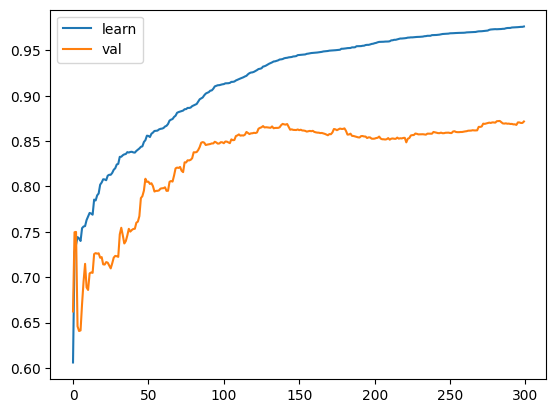

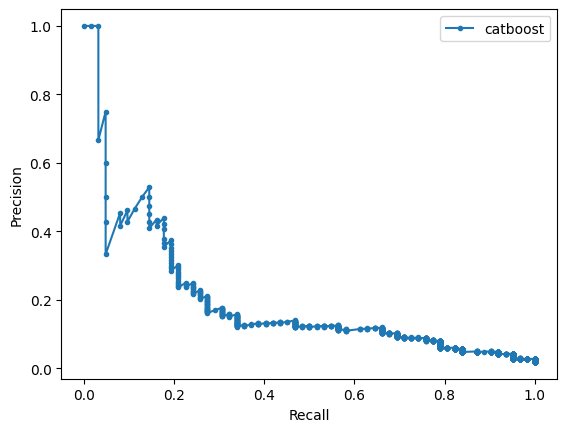

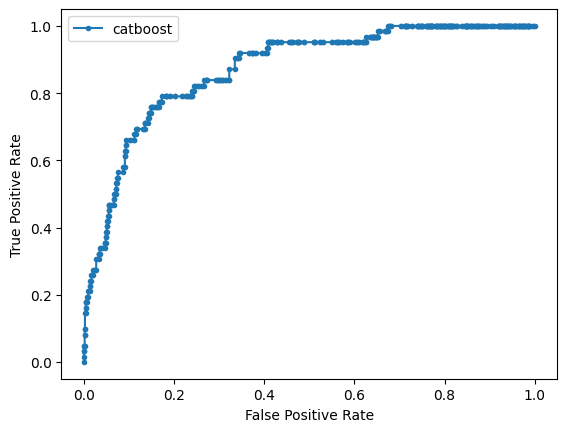

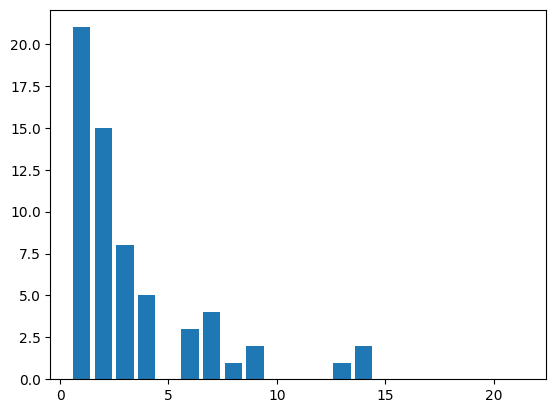

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


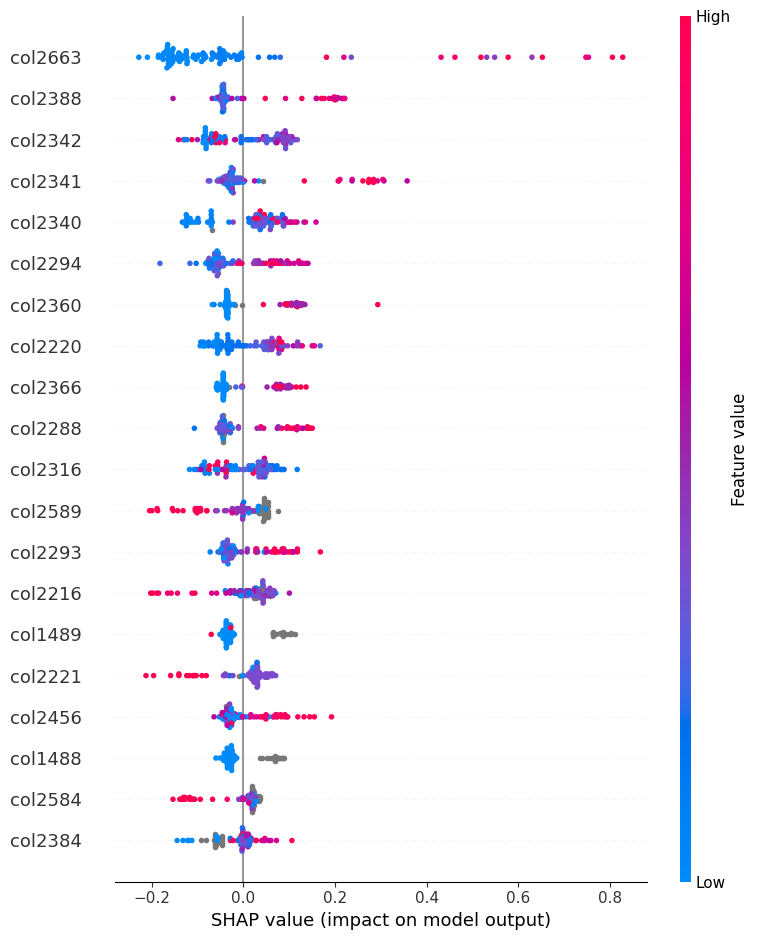

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


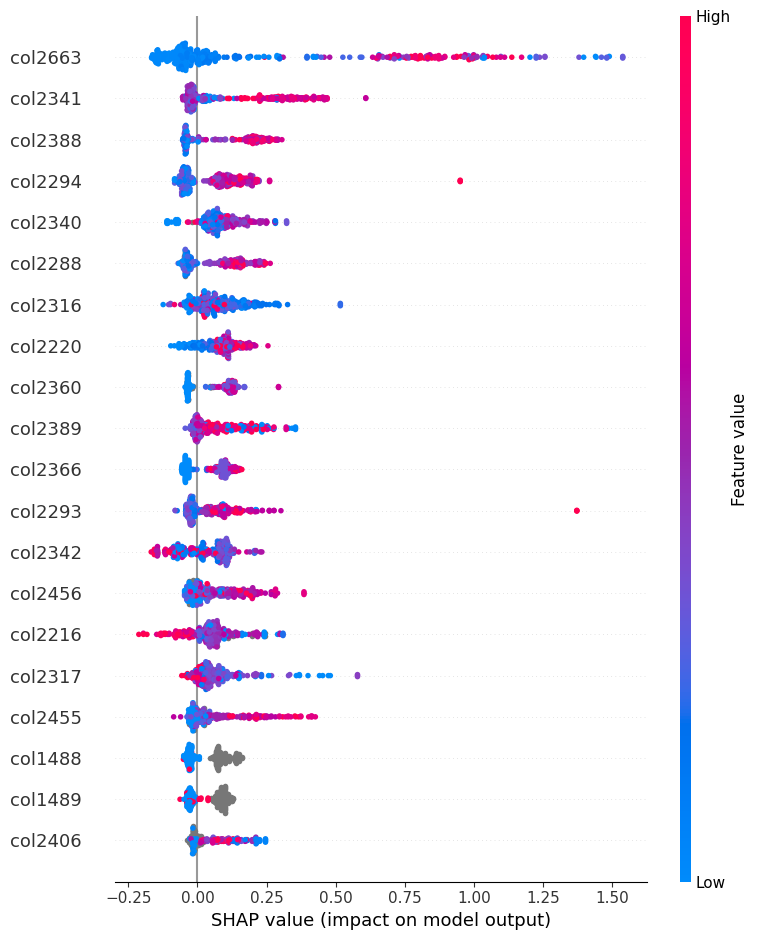

In [37]:
#train_df = train_df.loc[train_df['report_date'].isin(['2022-11-01', '2022-10-01'])]

pool_train = Pool(
    train_df.drop(['target', 'report_date'], axis=1),
    train_df['target'],
    cat_features = list(
        train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop('target', axis=1),
    test_df['target'],
    cat_features = list(
        train_df.drop('target', axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = fit_catboost(pool_train,pool_val)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_pr_curve(test_df['target'], predictions)
plot_roc_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, train_df)

## Подбор гиперпараметров с BlockedTimeSeriesSplit

In [38]:
class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

In [40]:
_train_df = train_df.loc[train_df['report_date'].isin(['2022-08-01', '2022-07-01', '2022-06-01', '2022-05-01', '2022-04-01'])]
ones = _train_df.loc[_train_df['target']==1]
zeros = _train_df.loc[_train_df['target']==0].sample(ones.shape[0]*7,random_state=0)
_train_df = pd.concat([ones,zeros])
_train_df.shape

_test_df = train_df.loc[train_df['report_date'].isin(['2022-09-01', '2022-10-01', '2022-11-01'])]

feature_train = _train_df.drop(['target','report_date'], axis=1)
target_train = _train_df['target']
feature_test = _test_df.drop(['target','report_date'], axis=1)
target_test = _test_df['target']

def objective(trial):
    del_col = ['target', 'report_date']
    params = {
        "iterations": 300,
        "learning_rate": 0.05,
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample":trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel":trial.suggest_float("subsample", 0.05, 1.0),
        "min_data_in_leaf":trial.suggest_float("subsample", 0.05, 1.0)

    }
    model = CatBoostClassifier(
        **params,
        verbose = 0,
        eval_metric='AUC',
        random_seed = 0,
        cat_features = list(feature_train.select_dtypes('object').columns)
    )
    
    model.fit(feature_train, target_train)
    predictions = model.predict_proba(feature_test)[:,1]
    roc_auc = roc_auc_score(target_test, predictions)
    return roc_auc

sampler = optuna.samplers.TPESampler(seed=12345)
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=30,
    n_jobs=-1
)

[I 2023-09-10 04:24:42,591] A new study created in memory with name: no-name-187b097c-1e99-46a1-8d11-deb2963026fc
[I 2023-09-10 04:25:26,843] Trial 0 finished with value: 0.8408265947888589 and parameters: {'depth': 6, 'subsample': 0.4808474051644881}. Best is trial 0 with value: 0.8408265947888589.
[I 2023-09-10 04:25:42,924] Trial 3 finished with value: 0.8304851752021564 and parameters: {'depth': 7, 'subsample': 0.3801004760958141}. Best is trial 0 with value: 0.8408265947888589.
[I 2023-09-10 04:25:45,398] Trial 2 finished with value: 0.8235879005690325 and parameters: {'depth': 8, 'subsample': 0.2377018768108845}. Best is trial 0 with value: 0.8408265947888589.
[I 2023-09-10 04:26:25,354] Trial 4 finished with value: 0.8334651093141658 and parameters: {'depth': 6, 'subsample': 0.6756760338131159}. Best is trial 0 with value: 0.8408265947888589.
[I 2023-09-10 04:27:23,398] Trial 6 finished with value: 0.8387660976340221 and parameters: {'depth': 8, 'subsample': 0.39938294283711107}

In [ ]:
# def objective(trial):
#     del_col = ['target', 'report_date']
    
# #     ones = train_df.loc[train_df['target']==1]
# #     rus = RandomUnderSampler(sampling_strategy={0: 100*7})
# #     x,y = rus.fit_resample(train_df.drop('target', axis=1), _train_df['target'])
# #     train_df = pd.concat([x, y], axis=1)
    
#     btscv = BlockedTimeSeriesSplit(n_splits=3, train_size=5, test_size=3, col_date=train_df['report_date'])
    
#     params = {
#         "iterations": 300,
#         "learning_rate": 0.05,
#         "depth": trial.suggest_int("depth", 5, 10),
#         "subsample":tral.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel":tral.suggest_float("subsample", 0.05, 1.0),
#         "min_data_in_leaf":tral.suggest_int("subsample", 0.05, 1.0)

#     }
    
#     model = CatBoostClassifier(
#         **params,
#         verbose = 0,
#         eval_metric='AUC',
#         random_seed = 0,
#         cat_features = list(train_df.drop(del_col, axis=1).select_dtypes('object').columns)
#     )
    
#     roc_auc = cross_val_score(
#         model,
#         train_df.drop(del_col, axis=1),
#         train_df['target'],
#         cv=btscv,
#         scoring="roc_auc",
#         verbose = 3
#     ).mean()
    
#     return roc_auc

# sampler = optuna.samplers.TPESampler(seed=12345)
# study = optuna.create_study(study_name="CatBoost", direction="maximize", sampler=sampler)
# study.optimize(
#     objective,
#     n_trials=15,
#     n_jobs=-1
# )

In [ ]:
params =  study.best_params
print('Best hyperparameters:', params)
print('Best score:', study.best_value)

In [ ]:
pool_train = Pool(
    train_df.drop(['target','report_date'], axis=1),
    train_df['target'],
    cat_features = list(
        train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop(['target','report_date'], axis=1),
    test_df['target'],
    cat_features = list(
        train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = CatBoostClassifier(
    **params,
    iterations=300,
    learning_rate=0.07,
    eval_metric='AUC:hints=skip_train~false',
    random_seed=1
)
    
model.fit(
    pool_train,
    eval_set=pool_val,
    verbose=False
)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_pr_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, train_df)